In [1]:
!pip install tenseal scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import json
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tenseal as ts
import matplotlib.pyplot as plt

In [23]:
# Upload and load the data
uploaded = files.upload()
filename = list(uploaded.keys())[0]

with open(filename, "r") as f:
    data = json.load(f)

Saving IITD.json to IITD.json


In [33]:
# Extract all feature vectors
all_features = []
user_ids = []
for user_id, user_data in data.items():
    for feature_vec in user_data["features"]:
        all_features.append(feature_vec)
        user_ids.append(user_id)

all_features = np.array(all_features)
print(f"Total feature vectors: {all_features.shape}")

Total feature vectors: (2230, 5)


In [35]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_features)

# Split data into train and test
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)

# Autoencoder architecture
input_dim = X_train.shape[1]  # 5 dimensions
encoding_dim = 3  # Compress to 3 dimensions

In [36]:
# Build the autoencoder
input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim * 2, activation='relu')(input_layer)
encoder = layers.Dense(encoding_dim, activation='relu')(encoder)

decoder = layers.Dense(encoding_dim * 2, activation='relu')(encoder)
decoder = layers.Dense(input_dim, activation='linear')(decoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

In [37]:
# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=16,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1003 - val_loss: 0.8064
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8939 - val_loss: 0.7109
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8387 - val_loss: 0.6240
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6993 - val_loss: 0.5579
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7674 - val_loss: 0.5259
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6649 - val_loss: 0.5037
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5779 - val_loss: 0.4856
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6595 - val_loss: 0.4719
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5884 - val_loss: 0.4610
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5135 - val_loss: 0.4529
Epoch 11/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4838 - val_loss: 0.4450
Epoch 12/100
112/112 ━━━━━━━━━━━━━━━━━━━━

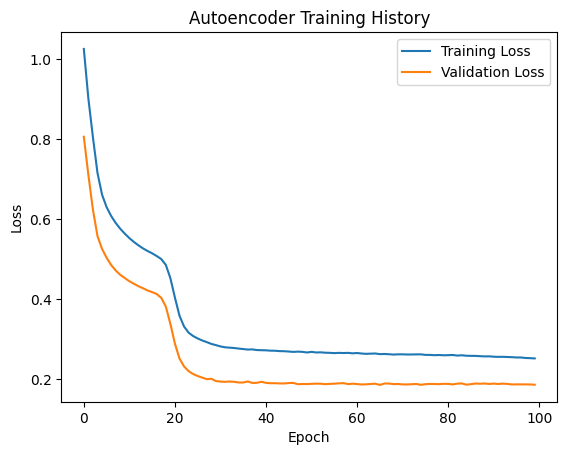

In [38]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [39]:
# Create encoder model for feature extraction
encoder_model = keras.Model(inputs=input_layer, outputs=encoder)

# Encode all features
encoded_features = encoder_model.predict(scaled_features)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [51]:
# Replace original features with encoded features in the data structure
encoded_data = {}
feature_index = 0
for user_id, user_data in data.items():
    encoded_data[user_id] = {
        "features": [],
        "file_names": user_data["file_names"]
    }

    for i in range(len(user_data["features"])):
        encoded_data[user_id]["features"].append(encoded_features[feature_index].tolist())
        feature_index += 1
# Now use the encoded_data for encryption instead of the original data
print("Sample encoded feature:", encoded_data["1"]["features"][0])
print("Original dimension: 5, Encoded dimension:", len(encoded_data["1"]["features"][0]))

Sample encoded feature: [0.0737568810582161, 4.938323974609375, 0.44936439394950867]
Original dimension: 5, Encoded dimension: 3


In [52]:
# Function to create CKKS context
def create_ckks_context():
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.generate_galois_keys()
    context.global_scale = 2 ** 40
    return context

# Create encryption context
context = create_ckks_context()
public_context = context.copy()
public_context.make_context_public()

In [53]:
# Encrypt all encoded feature vectors and store them
encrypted_database = {}

for user_id, user_data in encoded_data.items():
    encrypted_features = []
    for vec in user_data["features"]:
        enc_vec = ts.ckks_vector(public_context, vec)
        encrypted_features.append(enc_vec.serialize())
    encrypted_database[user_id] = encrypted_features

In [54]:
# EUCLIDEAN DISTANCE function for encrypted vectors
def euclidean_distance_encrypted(v1, v2, context):
    # Calculate squared Euclidean distance: ||v1 - v2||² = v1·v1 + v2·v2 - 2*v1·v2
    dot_v1 = v1.dot(v1)
    dot_v2 = v2.dot(v2)
    dot_v1_v2 = v1.dot(v2)

    # squared_distance = dot_v1 + dot_v2 - 2*dot_v1_v2
    squared_distance = dot_v1 + dot_v2 - dot_v1_v2 - dot_v1_v2

    # We return squared distance (faster) or can compute actual distance
    return squared_distance

In [67]:
# Test with a query from user 1 (first feature)
query_vec = encoded_data["50"]["features"][0]
enc_query = ts.ckks_vector(context, query_vec)

scores = []

for user_id, encrypted_feature_list in encrypted_database.items():
    for enc_feat_serialized in encrypted_feature_list:
        try:
            enc_feat = ts.ckks_vector_from(context, enc_feat_serialized)

            # Calculate squared Euclidean distance
            squared_dist = euclidean_distance_encrypted(enc_query, enc_feat, context)
            dist_value = squared_dist.decrypt()[0]

            # Convert distance to similarity (lower distance = higher similarity)
            # Using exponential decay: similarity = exp(-distance)
            similarity = np.exp(-dist_value)

            scores.append((user_id, similarity, dist_value))
        except Exception as e:
            print(f"Error comparing with User {user_id}: {e}")

In [68]:
# Sort by similarity (descending) and distance (ascending)
scores_similarity = sorted(scores, key=lambda x: x[1], reverse=True)
scores_distance = sorted(scores, key=lambda x: x[2])

print("Top 5 Matches by Similarity:")
for uid, sim, dist in scores_similarity[:5]:
    print(f"User {uid} → Similarity: {sim:.4f}, Distance: {dist:.4f}")

print("\nTop 5 Matches by Distance:")
for uid, sim, dist in scores_distance[:5]:
    print(f"User {uid} → Distance: {dist:.4f}, Similarity: {sim:.4f}")

Top 5 Matches by Similarity:
User 50 → Similarity: 1.0000, Distance: 0.0000
User 50 → Similarity: 0.9978, Distance: 0.0022
User 50 → Similarity: 0.9978, Distance: 0.0022
User 19 → Similarity: 0.9693, Distance: 0.0312
User 113 → Similarity: 0.9595, Distance: 0.0414

Top 5 Matches by Distance:
User 50 → Distance: 0.0000, Similarity: 1.0000
User 50 → Distance: 0.0022, Similarity: 0.9978
User 50 → Distance: 0.0022, Similarity: 0.9978
User 19 → Distance: 0.0312, Similarity: 0.9693
User 113 → Distance: 0.0414, Similarity: 0.9595


In [69]:
# Apply threshold based on similarity score (higher is better)
similarity_threshold = 0.97 # Adjust this based on your data (0-1 range)
best_match = scores_similarity[0]

if best_match[1] >= similarity_threshold:
    print(f"\nAuthenticated as User {best_match[0]} with similarity score {best_match[1]:.4f}")
else:
    print(f"\nAuthentication failed. Best match is User {best_match[0]} with similarity score {best_match[1]:.4f}")


Authenticated as User 50 with similarity score 1.0000


In [ ]:
"""# Test with a fake vector
fake_vec = np.random.rand(encoding_dim).tolist()
enc_fake_query = ts.ckks_vector(context, fake_vec)

fake_scores = []
for user_id, enc_feat_list in encrypted_database.items():
    for enc_feat_serialized in enc_feat_list:
        enc_feat = ts.ckks_vector_from(context, enc_feat_serialized)
        try:
            squared_dist = euclidean_distance_encrypted(enc_fake_query, enc_feat, context)
            dist_value = squared_dist.decrypt()[0]
            similarity = np.exp(-dist_value)  # Convert distance to similarity (0-1)
            fake_scores.append((user_id, similarity, dist_value))
        except Exception as e:
            print(f"Error comparing with User {user_id}: {e}")

fake_scores_similarity = sorted(fake_scores, key=lambda x: x[1], reverse=True)  # Sort by similarity

print("\nTop 5 Matches for Fake Vector (by Similarity):")
for uid, sim, dist in fake_scores_similarity[:5]:
    print(f"User {uid} → Similarity: {sim:.4f}, Distance: {dist:.4f}")

if fake_scores_similarity[0][1] >= similarity_threshold:
    print(f"\nFAKE vector accepted (this should not happen). Matched User {fake_scores_similarity[0][0]} with similarity {fake_scores_similarity[0][1]:.4f}")
else:
    print(f"\nFAKE vector correctly rejected. Highest similarity: {fake_scores_similarity[0][1]:.4f}")

"""

'# Test with a fake vector\nfake_vec = np.random.rand(encoding_dim).tolist()\nenc_fake_query = ts.ckks_vector(context, fake_vec)\n\nfake_scores = []\nfor user_id, enc_feat_list in encrypted_database.items():\n    for enc_feat_serialized in enc_feat_list:\n        enc_feat = ts.ckks_vector_from(context, enc_feat_serialized)\n        try:\n            squared_dist = euclidean_distance_encrypted(enc_fake_query, enc_feat, context)\n            dist_value = squared_dist.decrypt()[0]\n            similarity = np.exp(-dist_value)  # Convert distance to similarity (0-1)\n            fake_scores.append((user_id, similarity, dist_value))\n        except Exception as e:\n            print(f"Error comparing with User {user_id}: {e}")\n\nfake_scores_similarity = sorted(fake_scores, key=lambda x: x[1], reverse=True)  # Sort by similarity\n\nprint("\nTop 5 Matches for Fake Vector (by Similarity):")\nfor uid, sim, dist in fake_scores_similarity[:5]:\n    print(f"User {uid} → Similarity: {sim:.4f}, Dis

In [70]:
# Analyze similarity distribution
genuine_similarities = [sim for uid, sim, dist in scores if uid == "50"]
imposter_similarities = [sim for uid, sim, dist in scores if uid != "50"]

print(f"\nSimilarity Analysis:")
print(f"Genuine user mean similarity: {np.mean(genuine_similarities):.4f}")
print(f"Imposters mean similarity: {np.mean(imposter_similarities):.4f}")
print(f"Similarity separation: {np.mean(genuine_similarities) - np.mean(imposter_similarities):.4f}")


Similarity Analysis:
Genuine user mean similarity: 0.5514
Imposters mean similarity: 0.1694
Similarity separation: 0.3820


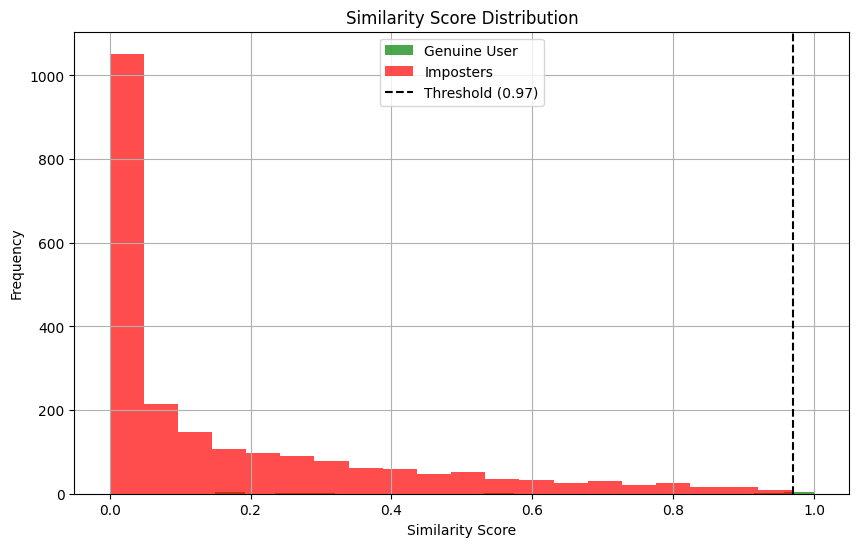

In [71]:
# Plot similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(genuine_similarities, alpha=0.7, label='Genuine User', bins=20, color='green')
plt.hist(imposter_similarities, alpha=0.7, label='Imposters', bins=20, color='red')
plt.axvline(x=similarity_threshold, color='black', linestyle='--', label=f'Threshold ({similarity_threshold})')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Similarity Score Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# Calculate accuracy metrics
true_positives = sum(1 for uid, sim, dist in scores if uid == "50" and sim >= similarity_threshold)
true_negatives = sum(1 for uid, sim, dist in scores if uid != "50" and sim < similarity_threshold)
false_positives = sum(1 for uid, sim, dist in scores if uid != "50" and sim >= similarity_threshold)
false_negatives = sum(1 for uid, sim, dist in scores if uid == "50" and sim < similarity_threshold)

accuracy = (true_positives + true_negatives) / len(scores)
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")


Performance Metrics:
Accuracy: 0.9969
Precision: 1.0000
Recall: 0.3000
True Positives: 3
True Negatives: 2220
False Positives: 0
False Negatives: 7


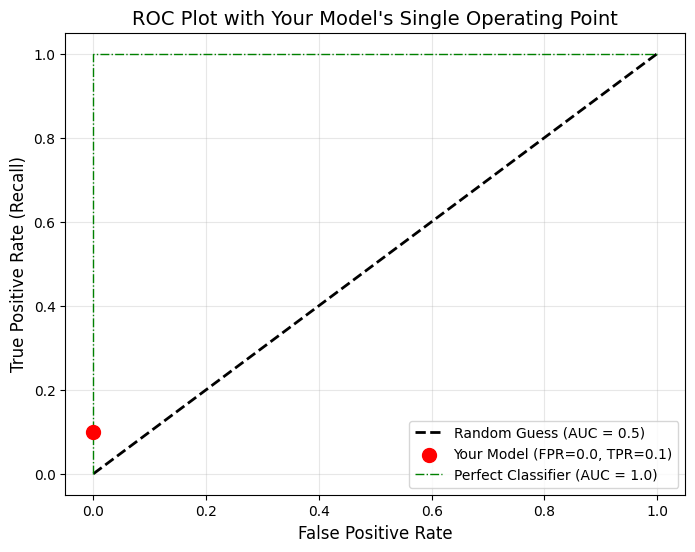

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Your calculated values
fpr = 0.0
tpr = 0.1 # This is the Recall

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)', lw=2)

# Plot the single point for your model
plt.scatter(fpr, tpr, color='red', s=100, zorder=3, label=f'Your Model (FPR={fpr}, TPR={tpr})')

# Plot a line representing a "perfect" classifer
plt.plot([0, 0, 1], [0, 1, 1], 'g-.', label='Perfect Classifier (AUC = 1.0)', lw=1)

# Format the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Plot with Your Model\'s Single Operating Point', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()